Simple Tag
https://www.pettingzoo.ml/mpe/simple_tag

> This is a predator-prey environment. Good agents (green) are faster and receive a negative reward for being hit by adversaries (red) (-10 for each collision). Adversaries are slower and are rewarded for hitting good agents (+10 for each collision). Obstacles (large black circles) block the way. By default, there is 1 good agent, 3 adversaries and 2 obstacles.

Baseline agent algorithm with experience replay buffer

In [2]:
import os
import time
import enum
import math
import random
import collections
import statistics
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class TimeDelta(object):
    def __init__(self, delta_time):
        """Convert time difference in seconds to days, hours, minutes, seconds.
        
        Parameters
        ==========
        delta_time : float
            Time difference in seconds.
        """
        self.fractional, seconds = math.modf(delta_time)
        seconds = int(seconds)
        minutes, self.seconds = divmod(seconds, 60)
        hours, self.minutes = divmod(minutes, 60)
        self.days, self.hours = divmod(hours, 24)
    
    def __repr__(self):
        return f"{self.days}-{self.hours:02}:{self.minutes:02}:{self.seconds + self.fractional:02}"

from pettingzoo.mpe import simple_tag_v2
from pettingzoo.utils import random_demo

# torch.autograd.set_detect_anomaly(True)

Arguments in instantiate environment.

- num_good: number of good agents
- num_adversaries: number of adversaries
- num_obstacles: number of obstacles
- max_cycles: number of frames (a step for each agent) until game terminates
- continuous_actions: Whether agent action spaces are discrete(default) or continuous

In [2]:
env.close()

NameError: name 'env' is not defined

In [3]:
env = simple_tag_v2.env(
    num_good=1,
    num_adversaries=1,
    num_obstacles=0,
    max_cycles=30,
    continuous_actions=False
).unwrapped

### What are the environment parameters?

Adversaries (red) capture non-adversary (green). The map is a 2D grid and everything is initialized in the region [-1, +1]. There doesn't seem to be position clipping for out of bounds, but non-adversary agent are penalized for out of bounds.
Agent's observation is a ndarray vector of concatenated data in the following order:

1. current velocity (2,)
2. current position (2,)
3. relative position (2,) of each landmark
4. relative position (2,) of each other agent
5. velocity (2,) of each other non-adversary agent

When there are 3 adverseries and 3 non-adversaries, then advarsary observation space is 24 dimensional and non-advarsary observation space is 22 dimensional.

The environment is sequential. Agents move one at a time. Agents are either `adversary_*` for adversary or `agent_*` for non-adversary.

Actions:

- 0 is NOP
- 1 is go left
- 2 is go right
- 3 is go down
- 4 is go up

### How to train the agents?

When loss is increasing for Double DQN, then increase the interval for updating target network.
<https://stackoverflow.com/questions/56964657/cartpole-v0-loss-increasing-using-dqn>

In [4]:
env.reset()

In [5]:
def get_agent_counts():
    all_agents = 0
    adversaries = 0
    for agent in env.world.agents:
        all_agents += 1
        adversaries += 1 if agent.adversary else 0
    good_agents = all_agents - adversaries
    return (adversaries, good_agents)

def process_config(config):
    for k, v in config.common.items():
        config.adversary[k] = v
        config.agent[k] = v

n_adversaries, n_good_agents = get_agent_counts()
config = AttrDict(
    discount = 0.99,
    epsilon = 0.1,
    n_episodes=20_000,
    batch_size=1,
    update_target_interval=32,
    report_interval=32,
    clip_grad_norm=5.0,
    lr=0.002,
    reward_scale=1,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    common=AttrDict(
        hidden_size=32,
        n_actions=env.action_space(env.agent_selection).n,
    ),
    adversary=AttrDict(
        n_agents=n_adversaries,
        observation_shape=env.observation_space("adversary_0").shape

    ),
    agent=AttrDict(
        n_agents=n_good_agents,
        observation_shape=env.observation_space("agent_0").shape
    )
)
process_config(config)
config

{'discount': 0.99,
 'epsilon': 0.1,
 'n_episodes': 20000,
 'batch_size': 1,
 'update_target_interval': 32,
 'report_interval': 32,
 'clip_grad_norm': 5.0,
 'lr': 0.002,
 'reward_scale': 1,
 'device': device(type='cuda'),
 'common': {'hidden_size': 32, 'n_actions': 5},
 'adversary': {'n_agents': 1,
  'observation_shape': (8,),
  'hidden_size': 32,
  'n_actions': 5},
 'agent': {'n_agents': 1,
  'observation_shape': (6,),
  'hidden_size': 32,
  'n_actions': 5}}

In [6]:
class Normalizer(object):
    def __init__(self, env):
        self.n_landmarks = len(env.world.landmarks)
        self.n_allagents = len(env.world.agents)
        self.n_good = sum(map(lambda a: not a.adversary, env.world.agents))
    
    @staticmethod
    def normalize_abs_pos(s):
        """Clip absolute position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -1.5, 1.5) / 1.5

    @staticmethod
    def normalize_rel_pos(s):
        """Clip relative position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -3, 3) / 3

    def __call__(self, obs):
        # normalize and clip positions
        norm_obs = obs.copy()
        # normalize velocity of current entity
        norm_obs[:2] = norm_obs[:2] / 1.3
        # clip/scale abs. position of current entity
        norm_obs[2:4] = self.normalize_abs_pos(norm_obs[2:4])
        # clip/scale rel. position of other entities
        n_range = self.n_landmarks + self.n_allagents - 1
        for i in range(n_range):
            norm_obs[4 + (2*i):4 + (2*(i + 1))] = self.normalize_rel_pos(
                norm_obs[4 + (2*i):4 + (2*(i + 1))]
            )
        # normalize velocity of other entities
        norm_obs[4 + (2*n_range):] = norm_obs[4 + (2*n_range):] / 1.3
        return norm_obs
    
class RewardsShaper(object):
    def __init__(self, env):
        self.n_landmarks = len(env.world.landmarks)
        # self.n_allagents = len(env.world.agents)
        self.name_to_idx = {agent.name: i for i, agent in enumerate(env.world.agents)}
        self.idx_to_name = {i: agent.name for i, agent in enumerate(env.world.agents)}
        self.goodagent_indices = [
            i for i, agent in enumerate(env.world.agents) if agent.name.startswith("agent")
        ]
        self.adversary_indices = [
            i for i, agent in enumerate(env.world.agents) if agent.name.startswith("adversary")
        ]
        # rdist - distance between adversary-good agent to start computing rewards.
        self.rdist = 2
        # collision_dist - distance between adversary-good agent to count collision.
        #    Based on PettingZoo numbers. 
        self.collision_dist = 0.075 + 0.05

    @staticmethod
    def bound(x):
        if x < 0.9:
            return 0
        if x < 1.0:
            return (x - 0.9) * 10
        return min(np.exp(2 * x - 2), 10)
        
    def __call__(self, agent_name, obs):
        """Compute reshaped rewards from observation for agent given agent name.
        Adversary: start gaining small rewards as it nears good agents.
        
        Good agent: starts gaining small penality as it nears bad agents.
        """
        _obs = obs[4 + (2*self.n_landmarks):]
        agent_idx = self.name_to_idx[agent_name]
        cum_r = 0.
        if agent_name.startswith("agent"):
            # penalty across all adversaries
            for adversary_idx in self.adversary_indices:
                # penalty from distance of adversary; penalty of collision
                other_idx = adversary_idx - 1 if agent_idx < adversary_idx else adversary_idx
                x, y = _obs[2*other_idx:(2*other_idx) + 2]
                d    = math.sqrt(x**2 + y**2)
                if d < self.collision_dist:
                    cum_r -= 10
                else:
                    cum_r -= min(max(1 -  (1/self.rdist)*d, 0), 1)
                
            # penalty from boudary based on PettingZoo
            pos = obs[2:4]
            cum_r -= self.bound(abs(pos[0]))
            cum_r -= self.bound(abs(pos[1]))
        
        elif agent_name.startswith("adversary"):
            # reward across all agents
            for goodagent_idx in self.goodagent_indices:
                # reward from distance to agent; reward of collision
                other_idx = goodagent_idx - 1 if agent_idx < goodagent_idx else goodagent_idx
                x, y = _obs[2*other_idx:(2*other_idx) + 2]
                d    = math.sqrt(x**2 + y**2)
                if d < self.collision_dist:
                    cum_r += 10
                else:
                    cum_r += min(max(1 -  (1/self.rdist)*d, 0), 1)
        
        return cum_r

normalize = Normalizer(env) # norm_obs = normalize(obs)
shapereward = RewardsShaper(env) # reward = shapereward(agent_name, obs)
loss_fn = torch.nn.MSELoss()

In [7]:
class SimpleTagNet(torch.nn.Module):
    """NN Model for the agents. Both good agents and adversaries use this model."""
        
    def __init__(self, config, agent_type):
        super().__init__()
        # self.config = config
        self.device      = config.device
        self.observation_size = math.prod(config[agent_type].observation_shape)
        self.n_actions   = config[agent_type].n_actions
        self.hidden_size = config[agent_type].hidden_size
        self.output_mlp = torch.nn.Sequential(
            torch.nn.Linear(self.observation_size, self.hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(self.hidden_size, self.n_actions)
        )
    
    def forward(self, observation):
        """Apply DQN to episode step.
        
        Parameters
        ==========
        observation : ndarray
            The observation vector obtained from the environment.
        
        Returns
        =======
        torch.Tensor
            Vector of Q-value associated with each action.
        """
        observation = normalize(observation)
        observation = torch.tensor(observation, dtype=torch.float, device=self.device)
        Q = self.output_mlp(observation)
        return Q

def choose_action(config, agent_type, Q, epsilon=0.05, is_val=False):
    if not is_val and random.random() < epsilon:
        return random.randrange(config[agent_type].n_actions)
    else:
        return torch.argmax(Q).item()

In [8]:
def run_episode(config, adversary_net, should_render=False, epsilon=0.05, is_val=False):
    """Run one episodes.
    
    inputs consist of observation, message (backprop), hidden (backprop) indexed by agent
    outputs consist of action, q-value of action (backprop), reward, done indexed by (step, agent)
    
    Returns
    =======
    AttrDict
        Contains episode metrics:
        - steps : number of steps. All agents take an action at each step.
        - reward : episodic rewards indexed by ('adversary', 'agent').
        - step_records : list of quantities produced indiced by step, ('adversary', 'agent'), agent index.
          Each step record has:
            + observation
            + Q
            + reward
            + done
        - loss : contains episodic losses indexed by ('adversary', 'agent'). To be updated by train_agents()
    """
    episode = AttrDict(
        steps=0,
        reward=AttrDict(adversary=0, agent=0),
        step_records=[],
        loss=AttrDict(adversary=0, agent=0)
    )
    n_agents = config.adversary.n_agents + config.agent.n_agents
    step_record = None
    
    env.reset()
    for agent_step_idx, agent_name in enumerate(env.agent_iter()):
        if agent_step_idx % n_agents == 0:
            episode.steps += 1
            step_record = AttrDict(adversary={}, agent={})
            episode.step_records.append(step_record)
            
        obs_curr, _reward, done, _ = env.last()
        reward = shapereward(agent_name, obs_curr)
        if should_render:
            env.render()
            time.sleep(0.05)
            if agent_name == "adversary_0":
                # print("rew, shaped rew", round(_reward, 2), round(reward, 2))
                # print("obs, normed obs", np.round(obs_curr, 2), np.round(normalize(obs_curr), 2))
                # print("obs, normed obs", np.round(obs_curr[4:6], 2), np.round(normalize(obs_curr[4:6]), 2))
                # print("obs, rew", np.round(normalize(obs_curr[4:6]), 2), reward)
                pass
        agent_type, agent_idx = agent_name.split("_")
        agent_idx = int(agent_idx)
        if done:
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                action=None,
                Q=None,
                reward=reward,
                done=done,
            )
            env.step(None)
            continue
        if agent_type == "agent":
            env.step(0)
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                action=0,
                Q=None,
                reward=reward,
                done=done,
            )
        else:
            # agent_type == "adversary"
            Q_curr = adversary_net(obs_curr)
            action = choose_action(config, agent_type, Q_curr, epsilon, is_val=is_val)
            env.step(action)
            step_record[agent_type][agent_idx] = AttrDict(
                # inputs to network
                observation=obs_curr,
                # outputs of network / inputs to environment
                action=action,
#                 Q=Q_curr,
                Q=None,
                # output of environment
                reward=reward,
                done=done,
            )
        episode.reward[agent_type] += reward
    
    if should_render:
        env.close()
    return episode

def train_agents(config, batch, adversary_net, adversary_target_net, adversary_optimizer):
    """Compute loss of episode and update agent weights.
    """
    device = config.device
    discount = torch.tensor(config.discount, dtype=torch.float, device=device)
    for episode in batch:
        for step_idx in range(episode.steps):
            for agent_idx in episode.step_records[step_idx].adversary.keys():
                curr_record = episode.step_records[step_idx].adversary[agent_idx]
                if curr_record.done:
                    # agent is done at this step
                    continue
                adversary_optimizer.zero_grad()
                next_record = episode.step_records[step_idx + 1].adversary[agent_idx]
                r = torch.tensor(next_record.reward, dtype=torch.float, device=device)
                y = None
                if next_record.done:
                    # agent terminates at next step
                    y = r
                else:
                    next_o = next_record.observation
                    target_Q = adversary_target_net(next_o)
                    max_target_Q = torch.max(target_Q)
                    y = r + discount*max_target_Q
                curr_o = curr_record.observation
                u = curr_record.action
#                 Q = curr_record.Q
                Q = adversary_net(curr_o)
                Q_u = Q[u]
                # adversary_loss = torch.pow(y - Q_u, 2.)
                adversary_loss = loss_fn(y, Q_u)
                adversary_loss.backward()#retain_graph=True)
                
                show_norms = False
                if show_norms:
                    norms = [p.grad.detach().data.norm().item() for p in adversary_net.parameters()]
                    print("norm of gradiants", *np.round(norms, 2))
                    
                torch.nn.utils.clip_grad_norm_(adversary_net.parameters(), config.clip_grad_norm)
                adversary_optimizer.step()
                episode.loss.adversary += adversary_loss.item()

def train(config):
    """
    - Use parameter sharing between agents of the same class.
    - Good agents use one RL model, adversaries use another RL model.
      Train the agents side by side.
    - Separate, disjoint communication channels for two classes of agents,
      maintained by a container to store the messages.
    """
    eps_start = 0.9
    eps_end = 0.05
    eps_decay = 0.9996
    epsilon = eps_start
        
    print("Training the agents...")
    os.makedirs("models/batched-baseline-test", exist_ok=True)
    t0 = time.time()
    device = config.device
    adversary_net = SimpleTagNet(config, "adversary").to(device)
    adversary_target_net = SimpleTagNet(config, "adversary").to(device)
    adversary_target_net.eval()
    print("Created the agent nets.")
    adversary_optimizer = torch.optim.SGD(adversary_net.parameters(), lr=config.lr)
    logger = AttrDict(
        episodic_losses=AttrDict(adversary=[], agent=[]),
        episodic_rewards=AttrDict(adversary=[], agent=[])
    )
    def update_targets():
        adversary_target_net.load_state_dict(adversary_net.state_dict())
    print("Initial update of target nets")
    update_targets()
    
    batch = []
    print("Beginning the episodes...")
    for episode_idx in range(config.n_episodes):
        # Run an episode
        episode = run_episode(config, adversary_net,
                              epsilon=epsilon,
                              should_render=episode_idx % config.report_interval == 0 and episode_idx > 0)
        batch.append(episode)
        epsilon = max(epsilon*eps_decay, eps_end)
        
        # Train on the episode
        if episode_idx % config.batch_size == 0 and episode_idx > 0:
            train_agents(config, batch, adversary_net,
                         adversary_target_net,
                         adversary_optimizer)
            batch = []
        
        # Logging the reward and los
        logger.episodic_losses.adversary.append(episode.loss.adversary)
        logger.episodic_losses.agent.append(episode.loss.agent)
        logger.episodic_rewards.adversary.append(episode.reward.adversary)
        logger.episodic_rewards.agent.append(episode.reward.agent)

        if episode_idx % config.update_target_interval == 0 and episode_idx > 0:
            # Update double network
            update_targets()
        
        if episode_idx % config.report_interval == 0 and episode_idx > 0:
            # Logging
            t1 = time.time()
            tdelta = TimeDelta(round(t1 - t0, 0))
            print(f"on episode {episode_idx}, curr epsilon {epsilon} (time taken so far: {tdelta})")
            mean_loss_adversary = statistics.fmean(logger.episodic_losses.adversary[-config.report_interval:])
            mean_reward_adversary = statistics.fmean(logger.episodic_rewards.adversary[-config.report_interval:])
            mean_reward_agent = statistics.fmean(logger.episodic_rewards.agent[-config.report_interval:])
            print(f"     mean loss: adversary {mean_loss_adversary}")
            print(f"     mean reward: adversary {mean_reward_adversary}, agent {mean_reward_agent}")
            torch.save(
                adversary_net.state_dict(),
                f"models/batched-baseline-test/adversary-net-{episode_idx}.pth"
            )
    
    return adversary_net, logger


In [9]:
env.close()

In [60]:
# train model
adversary_net, logger = train(config)

Training the agents...
Created the agent nets.
Initial update of target nets
Beginning the episodes...
on episode 32, curr epsilon 0.8881957186750149 (time taken so far: 0-00:00:5.0)
     mean loss: adversary 4.335041372105627
     mean reward: adversary 12.299065507474689, agent -16.9399692783983
on episode 64, curr epsilon 0.8768970195551845 (time taken so far: 0-00:00:10.0)
     mean loss: adversary 7.123546200681534
     mean reward: adversary 17.75816067658625, agent -19.337948817538834
on episode 96, curr epsilon 0.8657420506956067 (time taken so far: 0-00:00:15.0)
     mean loss: adversary 20.156717107418345
     mean reward: adversary 15.33488781204314, agent -17.44268913766236
on episode 128, curr epsilon 0.8547289837098901 (time taken so far: 0-00:00:20.0)
     mean loss: adversary 6.893682688550312
     mean reward: adversary 16.090239499464662, agent -21.4821190170497
on episode 160, curr epsilon 0.843856013470467 (time taken so far: 0-00:00:25.0)
     mean loss: adversary 

on episode 1344, curr epsilon 0.5254668652771747 (time taken so far: 0-00:03:32.0)
     mean loss: adversary 284.4607334878948
     mean reward: adversary 14.717709734111862, agent -17.831528625753805
on episode 1376, curr epsilon 0.5187824241305049 (time taken so far: 0-00:03:37.0)
     mean loss: adversary 294.4474524746332
     mean reward: adversary 13.288454372193822, agent -18.811491872873315
on episode 1408, curr epsilon 0.5121830154690322 (time taken so far: 0-00:03:42.0)
     mean loss: adversary 315.88384797321953
     mean reward: adversary 16.61266174118258, agent -17.298374175534025
on episode 1440, curr epsilon 0.5056675575982097 (time taken so far: 0-00:03:47.0)
     mean loss: adversary 338.5781288748419
     mean reward: adversary 15.425469323874143, agent -18.501526038975143
on episode 1472, curr epsilon 0.49923498258367954 (time taken so far: 0-00:03:52.0)
     mean loss: adversary 364.38993347387986
     mean reward: adversary 15.387455775349805, agent -18.039061333

on episode 2656, curr epsilon 0.3108722781462201 (time taken so far: 0-00:07:0.0)
     mean loss: adversary 791.3444952046124
     mean reward: adversary 18.282004026630485, agent -22.557420941004118
on episode 2688, curr epsilon 0.30691768541218833 (time taken so far: 0-00:07:5.0)
     mean loss: adversary 813.1830779053064
     mean reward: adversary 18.39435366087658, agent -23.19814301201207
on episode 2720, curr epsilon 0.30301339888038625 (time taken so far: 0-00:07:10.0)
     mean loss: adversary 791.3181445927622
     mean reward: adversary 16.010749477403593, agent -18.06200000222249
on episode 2752, curr epsilon 0.29915877860780254 (time taken so far: 0-00:07:15.0)
     mean loss: adversary 820.6916351924759
     mean reward: adversary 17.463834238508465, agent -20.72393308327508
on episode 2784, curr epsilon 0.2953531927921133 (time taken so far: 0-00:07:20.0)
     mean loss: adversary 788.9005891437403
     mean reward: adversary 14.342243834300001, agent -15.89209113539572

on episode 3968, curr epsilon 0.18391563713316872 (time taken so far: 0-00:10:27.0)
     mean loss: adversary 1441.0899995691207
     mean reward: adversary 16.60120050265947, agent -18.975592887177896
on episode 4000, curr epsilon 0.18157605430957724 (time taken so far: 0-00:10:32.0)
     mean loss: adversary 1405.8582838688758
     mean reward: adversary 14.754499327844655, agent -18.158060070580518
on episode 4032, curr epsilon 0.17926623321736299 (time taken so far: 0-00:10:37.0)
     mean loss: adversary 1431.644835308677
     mean reward: adversary 15.517011134815819, agent -17.046501933527594
on episode 4064, curr epsilon 0.17698579525883532 (time taken so far: 0-00:10:43.0)
     mean loss: adversary 1432.8053048284596
     mean reward: adversary 14.176421260899202, agent -16.96974648392786
on episode 4096, curr epsilon 0.17473436665242795 (time taken so far: 0-00:10:48.0)
     mean loss: adversary 1444.2909577041032
     mean reward: adversary 17.031061402605438, agent -17.6596

on episode 5280, curr epsilon 0.10880661918072287 (time taken so far: 0-00:13:56.0)
     mean loss: adversary 1892.4608646423835
     mean reward: adversary 17.117478418458134, agent -20.7538727850801
on episode 5312, curr epsilon 0.10742249490887563 (time taken so far: 0-00:14:1.0)
     mean loss: adversary 1935.0817396910775
     mean reward: adversary 16.6151294063351, agent -19.486540104033693
on episode 5344, curr epsilon 0.10605597802171082 (time taken so far: 0-00:14:6.0)
     mean loss: adversary 1938.1736985331095
     mean reward: adversary 19.250578263232132, agent -23.058896304497143
on episode 5376, curr epsilon 0.10470684453645349 (time taken so far: 0-00:14:11.0)
     mean loss: adversary 1949.3139880203353
     mean reward: adversary 15.300853117283598, agent -18.135345480319277
on episode 5408, curr epsilon 0.1033748733196038 (time taken so far: 0-00:14:16.0)
     mean loss: adversary 1971.9242112777329
     mean reward: adversary 16.448448329614145, agent -20.26840816

on episode 6592, curr epsilon 0.0643712550062648 (time taken so far: 0-00:17:25.0)
     mean loss: adversary 2317.4588354579264
     mean reward: adversary 12.528129902221687, agent -14.414975990094668
on episode 6624, curr epsilon 0.06355239107009693 (time taken so far: 0-00:17:30.0)
     mean loss: adversary 2384.2204356402926
     mean reward: adversary 14.477736729302842, agent -16.726801249304252
on episode 6656, curr epsilon 0.06274394386645807 (time taken so far: 0-00:17:35.0)
     mean loss: adversary 2358.06762852825
     mean reward: adversary 16.154063886497973, agent -17.109565197025297
on episode 6688, curr epsilon 0.06194578088454661 (time taken so far: 0-00:17:40.0)
     mean loss: adversary 2366.3304140960076
     mean reward: adversary 16.67759056013404, agent -19.982753235812766
on episode 6720, curr epsilon 0.061157771299225096 (time taken so far: 0-00:17:45.0)
     mean loss: adversary 2416.5499125027177
     mean reward: adversary 15.151516722271417, agent -20.9129

on episode 7968, curr epsilon 0.05 (time taken so far: 0-00:21:4.0)
     mean loss: adversary 2868.0974908652092
     mean reward: adversary 11.936112351471833, agent -14.998544405902077
on episode 8000, curr epsilon 0.05 (time taken so far: 0-00:21:9.0)
     mean loss: adversary 2893.7674384422353
     mean reward: adversary 11.838715052606352, agent -18.795535205306297
on episode 8032, curr epsilon 0.05 (time taken so far: 0-00:21:14.0)
     mean loss: adversary 2896.6583637300087
     mean reward: adversary 11.395340813567454, agent -15.509945733716302
on episode 8064, curr epsilon 0.05 (time taken so far: 0-00:21:19.0)
     mean loss: adversary 2791.342276950726
     mean reward: adversary 12.168322244815638, agent -17.80445306707351
on episode 8096, curr epsilon 0.05 (time taken so far: 0-00:21:24.0)
     mean loss: adversary 2805.3427062890814
     mean reward: adversary 11.583266375603158, agent -14.647574840130286
on episode 8128, curr epsilon 0.05 (time taken so far: 0-00:21:2

on episode 9376, curr epsilon 0.05 (time taken so far: 0-00:24:48.0)
     mean loss: adversary 3222.583840675011
     mean reward: adversary 17.40428334658962, agent -20.764681199546867
on episode 9408, curr epsilon 0.05 (time taken so far: 0-00:24:53.0)
     mean loss: adversary 3263.9061759023857
     mean reward: adversary 17.814229075251465, agent -21.576460842429046
on episode 9440, curr epsilon 0.05 (time taken so far: 0-00:24:58.0)
     mean loss: adversary 3361.2751593928633
     mean reward: adversary 16.828687838969504, agent -19.499516761591288
on episode 9472, curr epsilon 0.05 (time taken so far: 0-00:25:3.0)
     mean loss: adversary 3317.2929722421836
     mean reward: adversary 15.37456601921529, agent -20.0079620635888
on episode 9504, curr epsilon 0.05 (time taken so far: 0-00:25:8.0)
     mean loss: adversary 3276.181588830154
     mean reward: adversary 20.681458346203602, agent -23.481468177989754
on episode 9536, curr epsilon 0.05 (time taken so far: 0-00:25:13.0)

on episode 10784, curr epsilon 0.05 (time taken so far: 0-00:28:32.0)
     mean loss: adversary 3524.713934974375
     mean reward: adversary 18.340042310392473, agent -20.48195202145538
on episode 10816, curr epsilon 0.05 (time taken so far: 0-00:28:37.0)
     mean loss: adversary 3450.4098864977445
     mean reward: adversary 16.480458251726184, agent -18.14921940077499
on episode 10848, curr epsilon 0.05 (time taken so far: 0-00:28:42.0)
     mean loss: adversary 3634.441271502777
     mean reward: adversary 19.2173055857174, agent -21.320195451354227
on episode 10880, curr epsilon 0.05 (time taken so far: 0-00:28:47.0)
     mean loss: adversary 3692.329837626254
     mean reward: adversary 19.351991759498944, agent -20.833381386359562
on episode 10912, curr epsilon 0.05 (time taken so far: 0-00:28:52.0)
     mean loss: adversary 3622.8235861256885
     mean reward: adversary 17.130498479030617, agent -20.303359406910424
on episode 10944, curr epsilon 0.05 (time taken so far: 0-00:2

on episode 12192, curr epsilon 0.05 (time taken so far: 0-00:32:16.0)
     mean loss: adversary 3622.887664505513
     mean reward: adversary 15.728179489564388, agent -18.97608661402413
on episode 12224, curr epsilon 0.05 (time taken so far: 0-00:32:21.0)
     mean loss: adversary 3483.0312063717993
     mean reward: adversary 14.933506281859053, agent -16.630507515555987
on episode 12256, curr epsilon 0.05 (time taken so far: 0-00:32:26.0)
     mean loss: adversary 3421.157483720544
     mean reward: adversary 17.381597495732475, agent -21.222945376393962
on episode 12288, curr epsilon 0.05 (time taken so far: 0-00:32:31.0)
     mean loss: adversary 3541.2581329797927
     mean reward: adversary 15.641775105885213, agent -17.967956518131366
on episode 12320, curr epsilon 0.05 (time taken so far: 0-00:32:37.0)
     mean loss: adversary 3706.201185603205
     mean reward: adversary 16.411789681090955, agent -21.553221705629472
on episode 12352, curr epsilon 0.05 (time taken so far: 0-0

on episode 13600, curr epsilon 0.05 (time taken so far: 0-00:36:0.0)
     mean loss: adversary 3716.2483656508543
     mean reward: adversary 9.743720821043649, agent -12.078750512501397
on episode 13632, curr epsilon 0.05 (time taken so far: 0-00:36:5.0)
     mean loss: adversary 3872.8370045808138
     mean reward: adversary 17.875864599454474, agent -19.8807388623393
on episode 13664, curr epsilon 0.05 (time taken so far: 0-00:36:10.0)
     mean loss: adversary 3900.8049414505267
     mean reward: adversary 15.40868105735533, agent -17.62383422251694
on episode 13696, curr epsilon 0.05 (time taken so far: 0-00:36:16.0)
     mean loss: adversary 3880.0158635580387
     mean reward: adversary 16.266312184822635, agent -19.160944107067657
on episode 13728, curr epsilon 0.05 (time taken so far: 0-00:36:21.0)
     mean loss: adversary 4294.849824280876
     mean reward: adversary 19.541474698071394, agent -22.85681936423875
on episode 13760, curr epsilon 0.05 (time taken so far: 0-00:36:

on episode 15008, curr epsilon 0.05 (time taken so far: 0-00:39:45.0)
     mean loss: adversary 4420.927996270375
     mean reward: adversary 18.532890434718833, agent -20.64722238049577
on episode 15040, curr epsilon 0.05 (time taken so far: 0-00:39:50.0)
     mean loss: adversary 4464.2736794750435
     mean reward: adversary 19.685032153785084, agent -23.031604783892487
on episode 15072, curr epsilon 0.05 (time taken so far: 0-00:39:55.0)
     mean loss: adversary 4314.5898171440485
     mean reward: adversary 15.396104585623148, agent -19.898691566842718
on episode 15104, curr epsilon 0.05 (time taken so far: 0-00:40:1.0)
     mean loss: adversary 4103.039392693765
     mean reward: adversary 12.192114406171413, agent -16.939082779827686
on episode 15136, curr epsilon 0.05 (time taken so far: 0-00:40:6.0)
     mean loss: adversary 4172.321416154675
     mean reward: adversary 16.081834876257783, agent -18.91217330204521
on episode 15168, curr epsilon 0.05 (time taken so far: 0-00:4

on episode 16416, curr epsilon 0.05 (time taken so far: 0-00:43:31.0)
     mean loss: adversary 4571.222685735103
     mean reward: adversary 16.058189846624217, agent -18.516060233165103
on episode 16448, curr epsilon 0.05 (time taken so far: 0-00:43:36.0)
     mean loss: adversary 4698.932471103899
     mean reward: adversary 19.59072953090901, agent -21.85535795907658
on episode 16480, curr epsilon 0.05 (time taken so far: 0-00:43:41.0)
     mean loss: adversary 4726.53332188149
     mean reward: adversary 18.90284612645075, agent -26.417368873533523
on episode 16512, curr epsilon 0.05 (time taken so far: 0-00:43:46.0)
     mean loss: adversary 4838.528426382329
     mean reward: adversary 19.898158598344857, agent -23.957814450960687
on episode 16544, curr epsilon 0.05 (time taken so far: 0-00:43:51.0)
     mean loss: adversary 4839.608162248605
     mean reward: adversary 20.81889879639358, agent -22.244383081152144
on episode 16576, curr epsilon 0.05 (time taken so far: 0-00:43:5

on episode 17824, curr epsilon 0.05 (time taken so far: 0-00:47:16.0)
     mean loss: adversary 4810.081241938924
     mean reward: adversary 24.02721816733733, agent -29.968687717711664
on episode 17856, curr epsilon 0.05 (time taken so far: 0-00:47:21.0)
     mean loss: adversary 4703.313065069493
     mean reward: adversary 20.597289299388272, agent -25.124887732584813
on episode 17888, curr epsilon 0.05 (time taken so far: 0-00:47:26.0)
     mean loss: adversary 4727.879867911293
     mean reward: adversary 20.38166184951179, agent -24.480768464731383
on episode 17920, curr epsilon 0.05 (time taken so far: 0-00:47:31.0)
     mean loss: adversary 4713.809562123653
     mean reward: adversary 21.08221481652308, agent -24.212823688102247
on episode 17952, curr epsilon 0.05 (time taken so far: 0-00:47:36.0)
     mean loss: adversary 4773.925907915909
     mean reward: adversary 20.77261015896726, agent -23.924202510463477
on episode 17984, curr epsilon 0.05 (time taken so far: 0-00:47:

on episode 19232, curr epsilon 0.05 (time taken so far: 0-00:51:0.0)
     mean loss: adversary 4806.71433753004
     mean reward: adversary 19.51145043621055, agent -23.870864641165646
on episode 19264, curr epsilon 0.05 (time taken so far: 0-00:51:4.0)
     mean loss: adversary 4812.263913584222
     mean reward: adversary 21.621434316636176, agent -26.500475962312073
on episode 19296, curr epsilon 0.05 (time taken so far: 0-00:51:9.0)
     mean loss: adversary 4954.814355706347
     mean reward: adversary 21.141367691552805, agent -24.975991002267765
on episode 19328, curr epsilon 0.05 (time taken so far: 0-00:51:14.0)
     mean loss: adversary 4959.071629777094
     mean reward: adversary 21.184764266752342, agent -24.466244601451493
on episode 19360, curr epsilon 0.05 (time taken so far: 0-00:51:20.0)
     mean loss: adversary 4883.450210845083
     mean reward: adversary 15.34660076307898, agent -19.10923257040243
on episode 19392, curr epsilon 0.05 (time taken so far: 0-00:51:25.

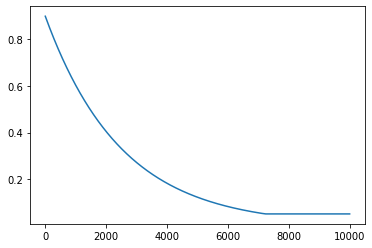

In [57]:
eps_start = 0.9
eps_end = 0.05
eps_decay = 0.9996
epsilon = eps_start

eps = [epsilon]
for i in range(10_000):
    epsilon = max((epsilon*eps_decay), eps_end)
    eps.append(epsilon)

plt.plot(eps)

In [10]:
# load adversary net
adversary_net = SimpleTagNet(config, "adversary").to(config.device)
adversary_net.load_state_dict(torch.load('./models/batched-baseline-test/adversary-net-19968.pth'))

<All keys matched successfully>

In [68]:
# save logs
with open("models/batched-baseline-test/log.json", "w") as f:
    json.dump(logger, f)

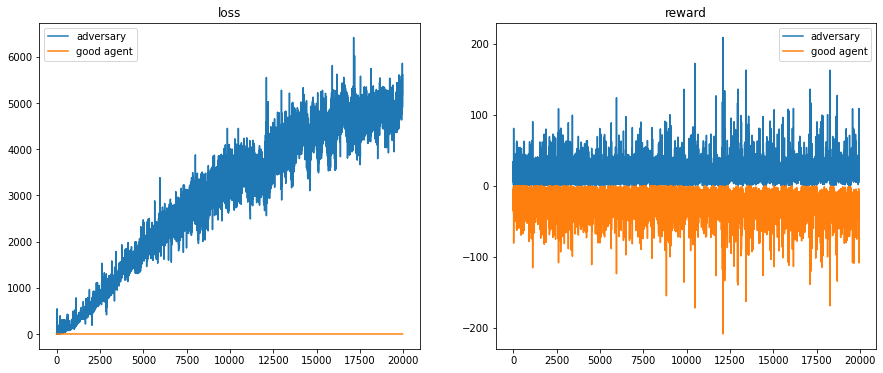

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.ravel()

axes[0].plot(logger.episodic_losses.adversary[50:], label="adversary")
axes[0].plot(logger.episodic_losses.agent[50:], label="good agent")
axes[0].set_title("loss")
axes[0].legend()

axes[1].plot(logger.episodic_rewards.adversary[50:], label="adversary")
axes[1].plot(logger.episodic_rewards.agent[50:], label="good agent")
axes[1].set_title("reward")
axes[1].legend()

In [ ]:
fig.savefig("models/batched-baseline-test/vis.png")

In [4]:
# load logs
with open("models/batched-baseline-test/log.json", "r") as f:
    logger = json.load(f)

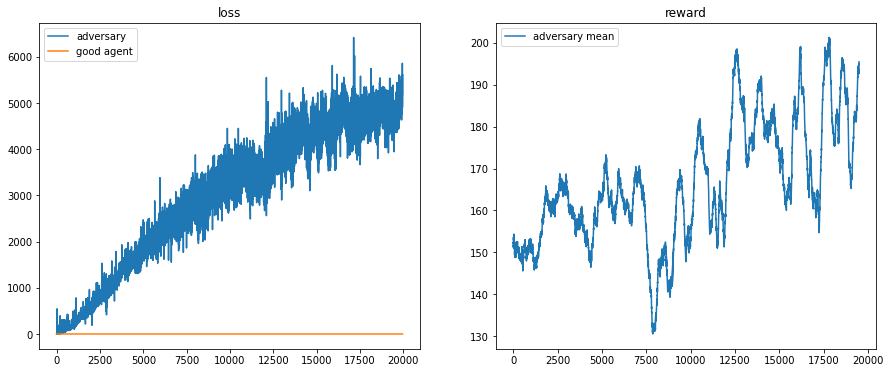

In [19]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def f(a, n):
    """Zero out beginning of last axis"""
    pad_width = [(0, 0) for _ in range(a.ndim - 1)] + [(n, 0)]
    return np.pad(a, pad_width, mode='constant', constant_values=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.ravel()

axes[0].plot(logger["episodic_losses"]["adversary"][50:], label="adversary")
axes[0].plot(logger["episodic_losses"]["agent"][50:], label="good agent")
axes[0].set_title("loss")
axes[0].legend()

adversary_episodic_rewards = np.array(logger["episodic_rewards"]["adversary"])*10
mean_adversary_episodic_rewards = f(moving_average(adversary_episodic_rewards, n=512), 0)
# axes[1].plot(adversary_episodic_rewards, label="adversary")
axes[1].plot(mean_adversary_episodic_rewards, label="adversary mean")
# axes[1].plot(logger["episodic_rewards"]["agent"][50:], label="good agent")
axes[1].set_title("reward")
axes[1].legend()

In [20]:
def visualize(config, adversary_net):
    adversary_net.eval()
    with torch.no_grad():
        return run_episode(config, adversary_net, should_render=True, is_val=True)

episode = visualize(config, adversary_net)
print("episode steps", episode.steps)
print("episode rewards", *episode.reward.items())

episode steps 31
episode rewards ('adversary', 34.37761549440293) ('agent', -34.37761549440293)
